# Scene text detection

In [1]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import shutil
import xml.etree.ElementTree as ET
from ultralytics import YOLO

from sklearn.model_selection import train_test_split

## Thiết lập module Text Detection

In [ ]:
# def extract_data_from_xml(root_dir):
#     xml_path = os.path.join(root_dir, 'words.xml')
#     tree = ET.parse(xml_path)
#     root = tree.getroot()

#     img_paths = []
#     img_sizes = []
#     img_labels = []
#     bboxes = []

#     for img in root:
#         bbs_of_img = []
#         labels_of_imgs = []

#         for bbs in img.findall('taggedRectangles'):
#             for bb in bbs:
#                 # check non-alphabet and non-number
#                 if not bb[0].text.isalnum():
#                     continue
#                 if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
#                     continue
                    
#                 bbs_of_img.append(
#                     [
#                         float(bb.attrib['x']),
#                         float(bb.attrib['y']),
#                         float(bb.attrib['width']),
#                         float(bb.attrib['height'])
#                     ]
#                 )
#                 labels_of_imgs.append(bb[0].text.lower())

#         img_path = os.path.join(root_dir, img[0].text)
#         img_paths.append(img_path)
#         img_sizes.append((int(img[1].attrib['x']), int(img[1].attrib['y'])))
#         bboxes.append(bbs_of_img)
#         img_labels.append(labels_of_imgs)
    
#     return img_paths, img_sizes, img_labels, bboxes

# dataset_dir = 'SceneTrialTrain'
# img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml(os.path.join(path, dataset_dir))


In [4]:
import os
import json

def extract_data_from_textocr(json_path, image_root):
    with open(json_path, 'r') as f:
        data = json.load(f)

    img_paths = []
    img_sizes = []
    img_labels = []
    bboxes = []

    imgs = data["imgs"]
    anns = data["anns"]

    # Track existing images by index to append to correct entry
    img_index_map = {}

    for ann_id, ann in anns.items():
        img_id = ann["image_id"]
        img_info = imgs[img_id]

        text = ann["utf8_string"].strip().lower()
        if not text.isalnum() or ' ' in text:
            continue

        bbox = ann["bbox"]  # [x, y, width, height]
        img_path = os.path.join(image_root, img_info["file_name"].split('/')[1])

        if img_id not in img_index_map:
            # New image entry
            img_index = len(img_paths)
            img_index_map[img_id] = img_index
            img_paths.append(img_path)
            img_sizes.append((img_info["width"], img_info["height"]))
            bboxes.append([bbox])
            img_labels.append([text])
        else:
            idx = img_index_map[img_id]
            bboxes[idx].append(bbox)
            img_labels[idx].append(text)

    return img_paths, img_sizes, img_labels, bboxes


json_file = './datasets/archive/TextOCR_0.1_train.json'
image_root = './datasets/archive/train_val_images/train_images'

img_paths, img_sizes, img_labels, bboxes = extract_data_from_textocr(json_file, image_root)

In [5]:
def convert_to_yolo_format(image_paths, image_sizes, bounding_boxes):
    yolo_data = []

    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        yolo_labels = []

        for bbox in bboxes:
            x, y, w, h = bbox

            # Calculate normalizedbounding box coordinates
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height  
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Set class_id to 0 because we only have one class
            class_id = 0

            #Convert to YOLO format
            yolo_label = f'{class_id} {center_x} {center_y} {normalized_width} {normalized_height}'
            yolo_labels.append(yolo_label)

        yolo_data.append((image_path, yolo_labels))
    return yolo_data

# Define class labels
class_labels = ['text']

yolo_data = convert_to_yolo_format(img_paths, img_sizes, bboxes)


In [6]:
def save_data(data, save_dir):
    # Create folder if not exists
    os.makedirs(save_dir, exist_ok=True)

    # Make images and labels folder
    os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'labels'), exist_ok=True)

    for image_path, yolo_labels in data:
        # Copy image to images folder
        shutil.copy(
            image_path,
            os.path.join(save_dir, 'images')
        )

        # Save labels to labels folder
        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, 'labels', f'{image_name}.txt'), 'w') as f:
            for label in yolo_labels:
                f.write(f"{label}\n")

seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True
train_data, test_data = train_test_split(yolo_data, test_size=val_size, random_state=seed, shuffle=is_shuffle)
test_data, val_data = train_test_split(test_data, test_size=test_size, random_state=seed, shuffle=is_shuffle)

In [7]:
save_yolo_data_dir = 'datasets/yolo_data_textocr'
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(save_yolo_data_dir, 'train')
save_val_dir = os.path.join(save_yolo_data_dir, 'val')
save_test_dir = os.path.join(save_yolo_data_dir, 'test')

save_data(train_data, save_train_dir)
save_data(test_data, save_test_dir)
save_data(val_data, save_val_dir)

In [ ]:
import yaml
# Create data.yaml file
data_yaml = {
    "path": "yolo_data",
    "train": "train/images",
    "val": "val/images",
    "test": "test/images",
    "nc": 1,
    "names": class_labels
}

yolo_yaml_path = os.path.join(save_yolo_data_dir, 'data.yaml')
with open(yolo_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

In [ ]:
model = YOLO("/kaggle/input/yolo_last/other/default/1/last.pt")

# Train model
results = model.train(
    data=yolo_yaml_path,
    epochs = 53,
    imgsz = 640,
    cache = True,
    patience = 20,
    plots = True,
)

Ultralytics 8.3.129 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/yolo_data/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=53, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/yolo_last/other/default/1/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, pl

100%|██████████| 755k/755k [00:00<00:00, 17.7MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512

train: Scanning /kaggle/working/datasets/yolo_data/train/labels... 17276 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17276/17276 [00:18<00:00, 956.12it/s]


train: New cache created: /kaggle/working/datasets/yolo_data/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (14.4GB RAM): 100%|██████████| 17276/17276 [01:17<00:00, 223.25it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1422.4±712.0 MB/s, size: 230.5 KB)


val: Scanning /kaggle/working/datasets/yolo_data/val/labels... 540 images, 0 backgrounds, 0 corrupt: 100%|██████████| 540/540 [00:00<00:00, 937.73it/s]

val: New cache created: /kaggle/working/datasets/yolo_data/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.5GB RAM): 100%|██████████| 540/540 [00:02<00:00, 209.55it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 53 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1080 [00:00<?, ?it/s]

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11m.pt")

# Train model
results = model.train(
    data=yolo_yaml_path,
    epochs = 100,
    imgsz = 640,
    cache = True,
    patience = 20,
    plots = True,
)

model_path = "./runs/detect/train/weights/best.pt"
model = YOLO( model_path )
metrics = model.val()

100%|██████████| 38.8M/38.8M [00:00<00:00, 197MB/s]


Ultralytics 8.3.128 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/yolo_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretrained=

100%|██████████| 755k/755k [00:00<00:00, 16.4MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 71.4MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3221.0±1271.3 MB/s, size: 265.0 KB)


train: Scanning /kaggle/working/datasets/yolo_data/train/labels... 17276 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17276/17276 [00:17<00:00, 991.72it/s] 


train: New cache created: /kaggle/working/datasets/yolo_data/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (14.4GB RAM): 100%|██████████| 17276/17276 [01:08<00:00, 253.68it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 432.4±66.4 MB/s, size: 230.5 KB)


val: Scanning /kaggle/working/datasets/yolo_data/val/labels... 540 images, 0 backgrounds, 0 corrupt: 100%|██████████| 540/540 [00:00<00:00, 927.50it/s]

val: New cache created: /kaggle/working/datasets/yolo_data/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.5GB RAM): 100%|██████████| 540/540 [00:01<00:00, 284.68it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      13.7G      1.362      1.094      1.028        725        640: 100%|██████████| 1080/1080 [12:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:10<00:00,  1.58it/s]

                   all        540      13661       0.58      0.566      0.538      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      12.4G      1.133     0.7498     0.9029        710        640: 100%|██████████| 1080/1080 [12:16<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.92it/s]

                   all        540      13661      0.549      0.539       0.51        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      11.4G      1.139      0.732     0.9049        364        640: 100%|██████████| 1080/1080 [12:13<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.95it/s]

                   all        540      13661      0.561      0.559      0.519      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      12.2G      1.089     0.6957     0.8977        546        640: 100%|██████████| 1080/1080 [12:12<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.582      0.577      0.542      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.3G     0.9872     0.6269     0.8804        289        640: 100%|██████████| 1080/1080 [12:11<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.593       0.59      0.562      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      14.3G     0.9158     0.5768     0.8675        430        640: 100%|██████████| 1080/1080 [12:12<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661      0.604      0.618      0.588      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100        13G     0.8644     0.5469      0.859        573        640: 100%|██████████| 1080/1080 [12:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.624      0.615      0.611      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      14.1G     0.8268     0.5236     0.8528        664        640: 100%|██████████| 1080/1080 [12:13<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.98it/s]

                   all        540      13661      0.606      0.623      0.592      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      13.4G     0.7987     0.5078     0.8487        342        640: 100%|██████████| 1080/1080 [12:11<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.95it/s]

                   all        540      13661      0.612      0.632      0.612      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      13.2G     0.7676      0.488     0.8444        424        640: 100%|██████████| 1080/1080 [12:11<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.98it/s]

                   all        540      13661        0.6       0.65       0.61      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      13.1G     0.7501     0.4786     0.8414        839        640:  83%|████████▎ | 900/1080 [10:10<02:02,  1.47it/s]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     11/100      11.7G     0.7473     0.4768      0.841        280        640: 100%|██████████| 1080/1080 [12:30<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.95it/s]

                   all        540      13661      0.641      0.636      0.634       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      11.1G     0.7266     0.4661     0.8387        407        640: 100%|██████████| 1080/1080 [12:11<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661      0.629      0.643      0.624      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      14.2G      0.712     0.4574     0.8358        422        640: 100%|██████████| 1080/1080 [12:14<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.632      0.642      0.637      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      12.9G      0.697     0.4491     0.8344        429        640: 100%|██████████| 1080/1080 [12:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.643       0.65      0.647      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      13.9G     0.6961      0.444     0.8318        651        640:   9%|▊         | 92/1080 [01:02<11:13,  1.47it/s]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     15/100      11.3G     0.6877     0.4438      0.833        444        640: 100%|██████████| 1080/1080 [12:35<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661      0.646      0.652      0.653      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      13.2G     0.6726     0.4344     0.8306       1189        640:  64%|██████▍   | 693/1080 [07:50<04:26,  1.45it/s]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     16/100      12.2G     0.6714     0.4343     0.8309        434        640: 100%|██████████| 1080/1080 [12:36<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661       0.63       0.66      0.649       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      13.5G     0.6616     0.4281     0.8292        479        640: 100%|██████████| 1080/1080 [12:13<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661      0.648      0.654       0.65      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      14.1G     0.6584     0.4264     0.8294        544        640: 100%|██████████| 1080/1080 [12:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.629      0.658      0.648      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      13.8G     0.6486     0.4214     0.8291        623        640: 100%|██████████| 1080/1080 [12:11<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.627      0.673      0.648      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      12.5G     0.6414     0.4162      0.826        678        640:  53%|█████▎    | 569/1080 [06:27<05:40,  1.50it/s]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     20/100      12.7G     0.6402     0.4157     0.8264        316        640: 100%|██████████| 1080/1080 [12:30<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.643      0.659      0.659      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      12.2G     0.6342     0.4114     0.8259        494        640: 100%|██████████| 1080/1080 [12:13<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.98it/s]

                   all        540      13661       0.65      0.661      0.661      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      13.2G     0.6271     0.4079     0.8248        580        640: 100%|██████████| 1080/1080 [12:15<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.655       0.66      0.666      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      14.5G     0.6205     0.4031     0.8234        557        640: 100%|██████████| 1080/1080 [12:13<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661      0.646      0.672      0.671      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      12.8G     0.6111     0.3982     0.8231        541        640:  99%|█████████▊| 1066/1080 [12:02<00:09,  1.45it/s]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     24/100      11.8G     0.6114     0.3984      0.823        458        640: 100%|██████████| 1080/1080 [12:31<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661      0.662       0.66       0.67      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      12.7G     0.6107     0.3983     0.8227        670        640: 100%|██████████| 1080/1080 [12:12<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.99it/s]

                   all        540      13661      0.662      0.661      0.677      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      12.6G     0.6014     0.3928      0.822        473        640: 100%|██████████| 1080/1080 [12:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661      0.656      0.671      0.676       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100        13G     0.5981     0.3912     0.8215        341        640: 100%|██████████| 1080/1080 [12:13<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.643      0.686      0.668      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      11.8G     0.5967     0.3912     0.8217        379        640: 100%|██████████| 1080/1080 [12:13<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.649      0.682      0.679      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100        12G     0.5872      0.386     0.8199        538        640: 100%|██████████| 1080/1080 [12:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.661       0.67      0.685      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      12.2G      0.586     0.3843     0.8195        514        640: 100%|██████████| 1080/1080 [12:14<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661      0.658      0.677      0.682      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      14.1G     0.5803     0.3804     0.8193        323        640: 100%|██████████| 1080/1080 [12:13<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.98it/s]

                   all        540      13661      0.649      0.688       0.68      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      14.1G     0.5766     0.3781     0.8191        584        640: 100%|██████████| 1080/1080 [12:14<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.95it/s]

                   all        540      13661       0.66      0.671      0.682      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      11.9G      0.569     0.3732     0.8175        500        640: 100%|██████████| 1080/1080 [12:11<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661      0.648      0.689      0.683      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      14.2G     0.5711     0.3745     0.8179        337        640: 100%|██████████| 1080/1080 [12:15<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.667      0.681      0.688      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      12.2G     0.5674     0.3703     0.8168        544        640: 100%|██████████| 1080/1080 [12:13<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661      0.661      0.681      0.689      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      12.8G     0.5649     0.3697     0.8166        273        640: 100%|██████████| 1080/1080 [12:16<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.675      0.674      0.689      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      14.1G     0.5575      0.367     0.8157        568        640: 100%|██████████| 1080/1080 [12:13<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.674      0.677      0.693      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      12.8G     0.5541     0.3639     0.8151        679        640: 100%|██████████| 1080/1080 [12:14<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.667      0.686      0.697      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      12.4G     0.5518      0.363     0.8155        552        640: 100%|██████████| 1080/1080 [12:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661      0.674      0.685      0.697      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      12.7G     0.5478     0.3605     0.8154        634        640: 100%|██████████| 1080/1080 [12:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661      0.678      0.681      0.699      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      13.6G     0.5475     0.3613     0.8146        661        640: 100%|██████████| 1080/1080 [12:13<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.93it/s]

                   all        540      13661      0.688      0.673        0.7      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      12.3G     0.5398     0.3554     0.8141        659        640: 100%|██████████| 1080/1080 [12:13<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.679      0.679      0.696       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      14.3G     0.5408     0.3552     0.8138        318        640: 100%|██████████| 1080/1080 [12:15<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.99it/s]

                   all        540      13661       0.68      0.677      0.698       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      12.7G     0.5336     0.3521     0.8131        530        640: 100%|██████████| 1080/1080 [12:13<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661      0.664      0.693        0.7      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      13.8G     0.5332     0.3501      0.813        736        640: 100%|██████████| 1080/1080 [12:14<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661      0.678       0.68        0.7      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100        14G     0.5247     0.3474     0.8116        605        640: 100%|██████████| 1080/1080 [12:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661       0.68      0.683      0.702      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100        14G     0.5257      0.347     0.8113        312        640: 100%|██████████| 1080/1080 [12:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661      0.687      0.679      0.703      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      13.1G     0.5248     0.3464     0.8121        438        640: 100%|██████████| 1080/1080 [12:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.685      0.681      0.702      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100        13G     0.5194      0.344     0.8114        359        640: 100%|██████████| 1080/1080 [12:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661      0.685      0.682      0.702      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      11.6G     0.5195     0.3431     0.8113        736        640:  52%|█████▏    | 566/1080 [06:23<05:44,  1.49it/s]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     50/100      11.2G     0.5202     0.3437      0.811        510        640: 100%|██████████| 1080/1080 [12:35<00:00,  1.43it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.98it/s]

                   all        540      13661      0.683      0.683      0.703      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      13.8G      0.514     0.3395     0.8105        827        640: 100%|██████████| 1080/1080 [12:13<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        540      13661      0.681      0.685      0.704      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      12.4G     0.5124     0.3387     0.8105        685        640:  96%|█████████▌| 1035/1080 [11:44<00:30,  1.47it/s]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     52/100      11.5G      0.512     0.3385     0.8104        710        640: 100%|██████████| 1080/1080 [12:35<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:09<00:00,  1.89it/s]

                   all        540      13661      0.684       0.68      0.705      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      14.3G     0.5175      0.341     0.8108        613        640: 100%|██████████| 1080/1080 [12:13<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.98it/s]

                   all        540      13661      0.685      0.682      0.705      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      14.5G     0.5059     0.3363     0.8103        444        640: 100%|██████████| 1080/1080 [12:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all        540      13661      0.685      0.684      0.706      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      12.9G     0.5063     0.3339     0.8085        477        640:  26%|██▋       | 285/1080 [03:13<08:48,  1.50it/s]

C:\Users\admin\AppData\Local\Temp\ipykernel_21236\72271723.py:31: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(height, width, 3)


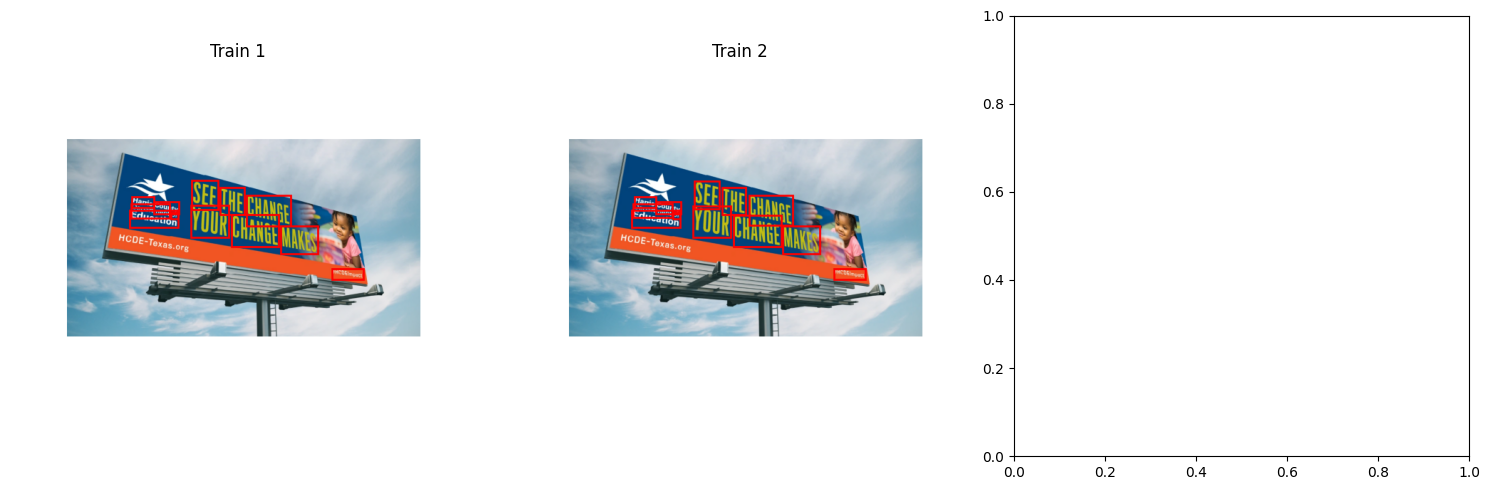

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def text_detection(img_path, text_det_model):
    text_det_results = text_det_model(img_path, verbose=False)[0]

    bboxes = text_det_results.boxes.xyxy.tolist()
    classes = text_det_results.boxes.cls.tolist()
    names = text_det_results.names
    confs = text_det_results.boxes.conf.tolist()

    return bboxes, classes, names, confs

def draw_detections(img, detections):
    """Draw bounding boxes on an image."""
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.axis('off')

    for bbox in detections:
        x1, y1, x2, y2 = bbox
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(rect)

    fig.canvas.draw()
    # Convert figure to numpy image
    width, height = fig.canvas.get_width_height()
    image_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(height, width, 3)
    plt.close(fig)
    return image_array

def predict(img_path, text_det_model):
    # Detection
    bboxes, classes, names, confs = text_detection(img_path, text_det_model)

    # Load the image
    img = Image.open(img_path).convert('RGB')

    # Draw and return the annotated image
    annotated_img = draw_detections(img, bboxes)
    return annotated_img

# === Main visualization ===
text_det_model_path = [
    './runs/detect_textocr_2/train/weights/best.pt',
    './runs/detect_textocr_2/train2/best.pt',
    './runs/detect_textocr_2/train3/best.pt'
]
img_path = 'tt.webp'

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    yolo = YOLO(text_det_model_path[i])
    annotated_image = predict(img_path, yolo)

    axes[i].imshow(annotated_image)
    axes[i].axis('off')
    axes[i].set_title(f"Train {i+1}")

plt.tight_layout()
plt.show()


In [11]:
model = YOLO('./Final release/best results/scene detection/best.pt')

In [12]:
results = model.val(data='./yolo_data/data.yaml')

Ultralytics 8.3.62  Python-3.12.1 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


val: Scanning E:\LapTrinh\PROJECT\ML\xulyanh\scene text detection\yolo_data\val\labels.cache... 540 images, 0 backgrounds, 0 corrupt: 100%|██████████| 540/540 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:50<00:00,  1.48s/it]


                   all        540      13661      0.748        0.7      0.764      0.541
Speed: 0.4ms preprocess, 66.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to e:\LapTrinh\PROJECT\ML\xulyanh\scene text detection\runs\detect\val6


In [ ]:
results.results_dict()

{'metrics/precision(B)': 0.7475142150045128,
 'metrics/recall(B)': 0.6996559549081326,
 'metrics/mAP50(B)': 0.7637003458991284,
 'metrics/mAP50-95(B)': 0.5410400100886019,
 'fitness': 0.5633060436696545}